In [1]:
%matplotlib notebook

%load_ext autoreload
%autoreload 2

#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from keras.models import load_model

from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from models import save_model, generate_model_CNN, plot_performance
from generators import generator, decode

Using TensorFlow backend.


## Load model

In [2]:
ls models

20190312-15:17:31_0.h5    20190312-15:41:17_200.h5  20190312-16:54:53_150.h5
20190312-15:18:18_100.h5  20190312-16:54:47_250.h5
20190312-15:22:34_500.h5  20190312-16:54:52_50.h5


In [3]:
model_path = os.path.join('models', os.listdir('models')[-1])


model_path = os.path.join('models', '20190312-15:18:18_100.h5')
model = load_model(model_path)

## Load data

In [4]:
X_load = np.load('../data/processed_data/m4015_session2/X_serial.npy')
Y_load = np.load('../data/processed_data/m4015_session2/y_serial.npy')

# X_load = np.load('../data/processed_data/m4017_session3/X_serial.npy')
# Y_load = np.load('../data/processed_data/m4017_session3/y_serial.npy')

# X_load = np.load('../data/processed_data/m4019_session1/X_serial.npy')
# Y_load = np.load('../data/processed_data/m4019_session1/y_serial.npy')

# X_load = np.load('../data/processed_data/m4020_session2/X_serial.npy')
# Y_load = np.load('../data/processed_data/m4020_session2/y_serial.npy')

# X_load = np.load('../data/processed_data/m4021_session1/X_serial.npy')
# Y_load = np.load('../data/processed_data/m4021_session1/y_serial.npy')

res = tf.one_hot(Y_load, depth=2)
with tf.Session() as sess:
    Y_load = (sess.run(res))

    
split_index = int(X_load.shape[0]*0.8)
X_val = X_load[split_index:]
Y_val = Y_load[split_index:]

In [5]:
predict_early = 100

In [6]:
batch_size = 1000
n_hidden = 100

validate_generator = generator(X_val, Y_val, batch_size*10, n_hidden, predict_early=predict_early)
X_trial, y_trial, = next(validate_generator)
res = model.predict(X_trial)

threshold=0.992

y_true = decode(y_trial, threshold=threshold)
y_pred = decode(res, threshold=threshold)

In [7]:
print('precision_score: ', np.round(precision_score(y_true, y_pred, average='binary', pos_label=1), decimals=3))
print('recall_score: ', np.round(recall_score(y_true, y_pred, average='binary', pos_label=1), decimals=3))
print('')
print('precision_score: ', np.round(precision_score(y_true, y_pred, average='binary', pos_label=0), decimals=3))
print('recall_score: ', np.round(recall_score(y_true, y_pred, average='binary', pos_label=0), decimals=3))

precision_score:  0.65
recall_score:  0.164

precision_score:  0.987
recall_score:  0.999


# Classical measure

In [8]:
threshold = np.arange(0., 1., 1.e-3)
x = np.zeros_like(threshold)
y = np.zeros_like(threshold)

for i, t in enumerate(threshold):
    y_true = decode(y_trial, threshold=t)
    y_pred = decode(res, threshold=t)
    
    true_mask = y_true==0
    x[i] = np.sum(y_pred[true_mask]==0) / np.sum(true_mask)
    
    true_mask = y_true==1 
    y[i] = np.sum(y_pred[true_mask]==1) / np.sum(true_mask)

<IPython.core.display.Javascript object>


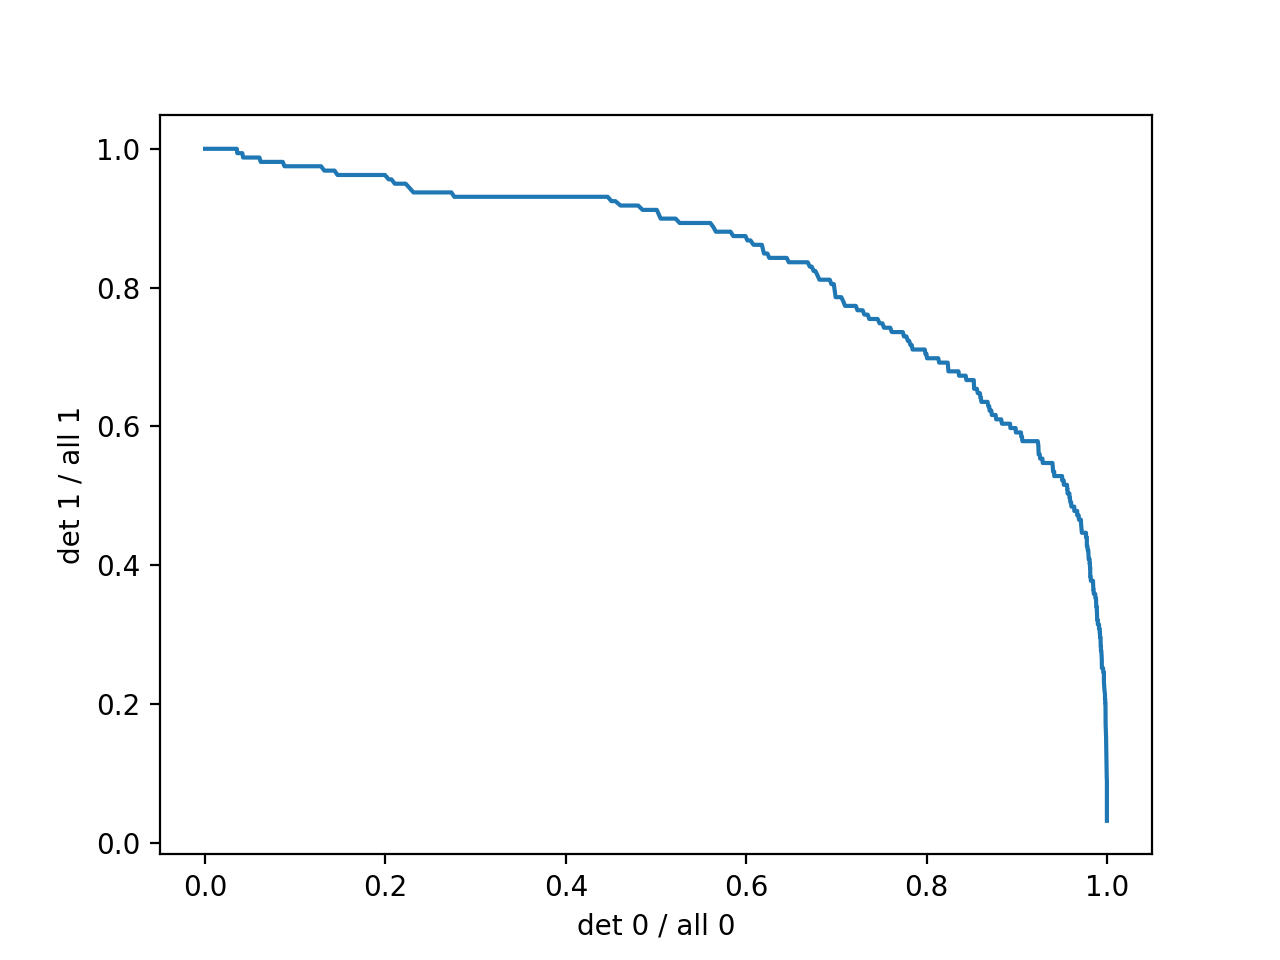

In [9]:
plt.figure()
plt.plot(x,y)
plt.xlabel('det 0 / all 0')
plt.ylabel('det 1 / all 1')
plt.savefig('plots/test1.pdf')
plt.show()

# New stuff measure

In [10]:
threshold = np.arange(0., 1., 1.e-3)
x = np.zeros_like(threshold)
y = np.zeros_like(threshold)

for i, t in enumerate(threshold):
    y_true = decode(y_trial, threshold=t)
    y_pred = decode(res, threshold=t)
    x[i] = precision_score(y_true, y_pred, average='binary', pos_label=1)
    y[i] = recall_score(y_true, y_pred, average='binary', pos_label=1)

<IPython.core.display.Javascript object>


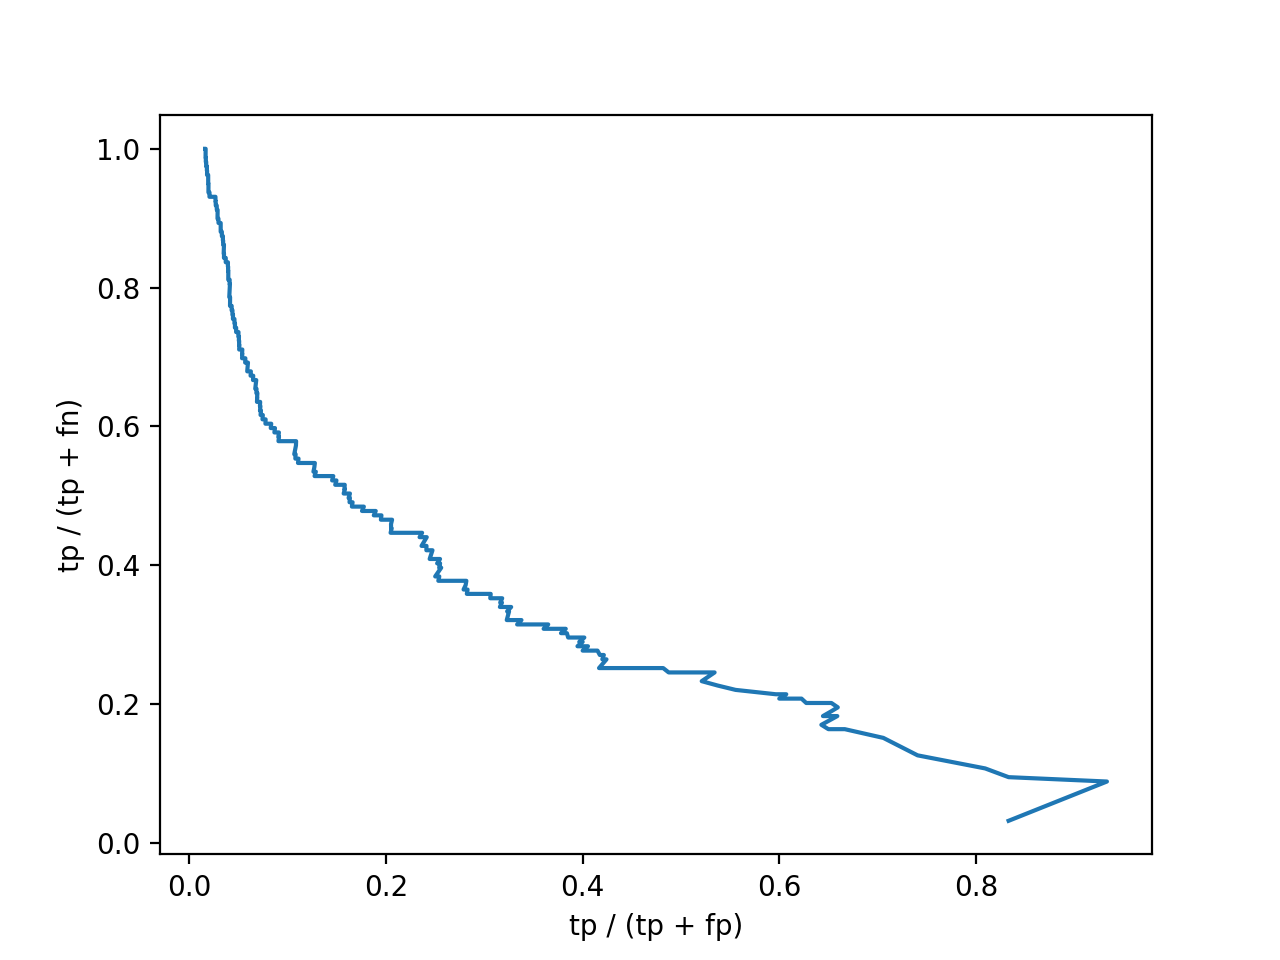

In [11]:
plt.figure()
plt.plot(x,y)
plt.xlabel('tp / (tp + fp)')
plt.ylabel('tp / (tp + fn)')
plt.savefig('plots/test1.pdf')
plt.show()

In [12]:
threshold=0.5

y_true = decode(y_trial, threshold=threshold)
y_pred = decode(res, threshold=threshold)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      9841
           1       0.08      0.61      0.14       159

   micro avg       0.88      0.88      0.88     10000
   macro avg       0.53      0.75      0.53     10000
weighted avg       0.98      0.88      0.92     10000



In [13]:
print(confusion_matrix(y_true, y_pred))

[[8667 1174]
 [  62   97]]
